In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MaxAbsScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')
# Set display dataframe
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('df.csv')
print(df)

       stretch      stress    C10
0     1.074074    2.007858   4.51
1     1.148148    4.034433   4.51
2     1.222222    6.094321   4.51
3     1.296296    8.198779   4.51
4     1.370370   10.356631   4.51
5     1.444444   12.574891   4.51
6     1.518519   14.859204   4.51
7     1.592593   17.214167   4.51
8     1.666667   19.643556   4.51
9     1.740741   22.150506   4.51
10    1.814815   24.737642   4.51
11    1.888889   27.407175   4.51
12    1.962963   30.160982   4.51
13    2.037037   33.000669   4.51
14    2.111111   35.927615   4.51
15    2.185185   38.943013   4.51
16    2.259259   42.047898   4.51
17    2.333333   45.243175   4.51
18    2.407407   48.529637   4.51
19    2.481481   51.907983   4.51
20    2.555556   55.378830   4.51
21    2.629630   58.942726   4.51
22    2.703704   62.600159   4.51
23    2.777778   66.351565   4.51
24    2.851852   70.197335   4.51
25    2.925926   74.137819   4.51
26    3.000000   78.173333   4.51
27    1.133333    1.978290   2.46
28    1.266667

In [3]:
#Shuffle and Separate into test, validation and train series by C10

aux_inds, test_inds  = next(GroupShuffleSplit(test_size=0.1, n_splits=1, random_state = None).split(df, groups=df.C10))

aux=df.iloc[aux_inds, :]

In [4]:
train_inds, val_inds  = next(GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = None).split(aux, groups=aux.C10))

#Get testing data
df_test=df.iloc[test_inds, :]

#Get training and  validation data
df_val=df.iloc[val_inds, :]

df_training=df.iloc[train_inds, :]

In [5]:
X_train=df_training.drop('C10',axis=1)
y_train=df_training.C10

X_val=df_val.drop('C10',axis=1)
y_val=df_val.C10

X_test=df_test.drop('C10',axis=1)
y_test=df_test.C10

In [6]:
#Scale Data using MaxAbsScaler
scaler = MaxAbsScaler()
X_train.stretch=scaler.fit_transform(X_train.stretch.values.reshape(-1, 1))
X_train.stress=scaler.fit_transform(X_train.stress.values.reshape(-1, 1))

X_val.stretch=scaler.fit_transform(X_val.stretch.values.reshape(-1, 1))
X_val.stress=scaler.fit_transform(X_val.stress.values.reshape(-1, 1))

X_test.stretch=scaler.fit_transform(X_test.stretch.values.reshape(-1, 1))
X_test.stress=scaler.fit_transform(X_test.stress.values.reshape(-1, 1))

In [7]:
input_shape=X_train.shape[1]

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model=keras.Sequential([layers.Dense(units=256, activation='relu', input_shape=[2]),
                        #layers.Dropout(rate=0.3),
                        layers.Dense(units=128, activation='relu'),
                        #layers.Dropout(rate=0.3),
                        layers.Dense(units=64, activation='relu'),
                        #layers.Dropout(rate=0.3),
                        layers.Dense(units=1),
                       ])

model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)

2021-11-26 15:18:07.424984: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Minimum Validation Loss: 0.4903


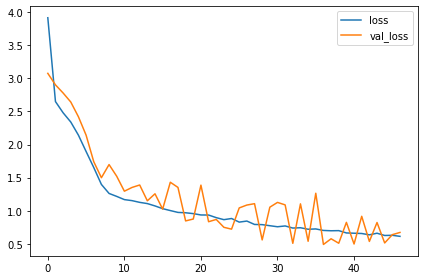

In [8]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=60,
    epochs=100,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

In [9]:
# Predict with all validation observations
val_predictions = model.predict(X_test)



In [10]:
val_mae = mean_absolute_error(y_test,val_predictions)
print("The mean absolute error is:")
print(val_mae)

The mean absolute error is:
0.6219102553552965


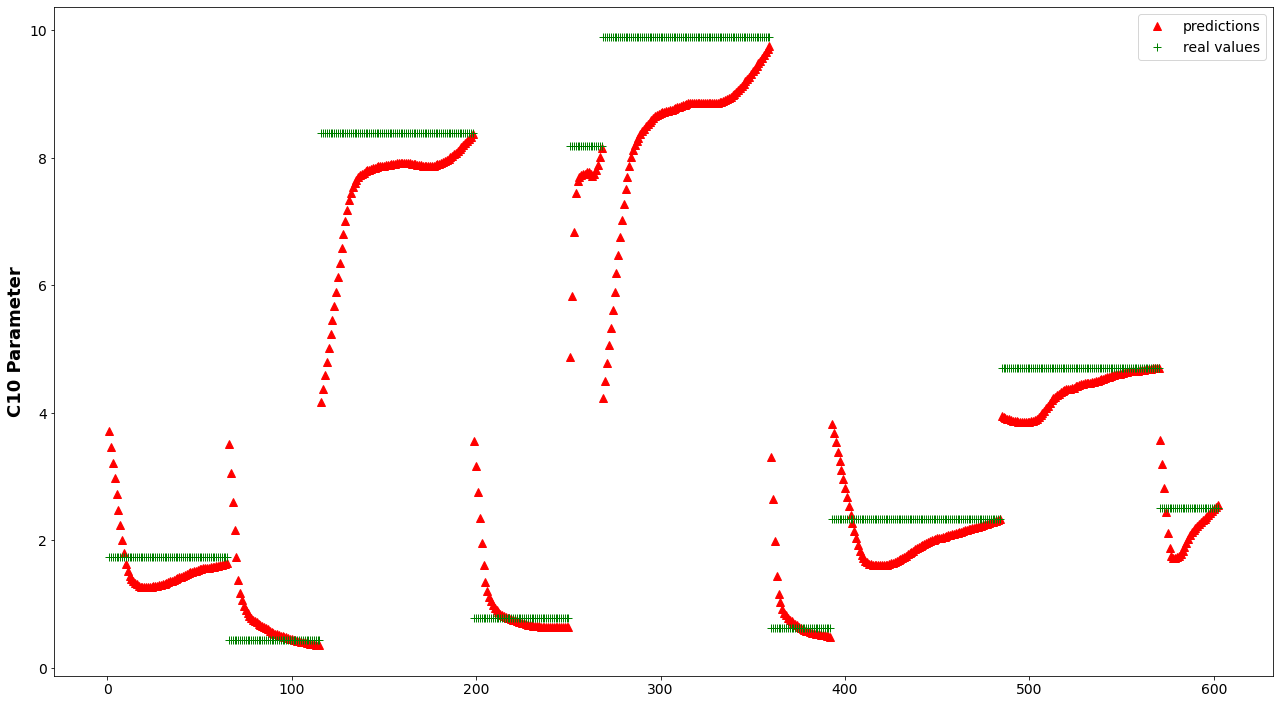

In [11]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

t = np.arange(1,y_test.shape[0]+1, 1)

f = plt.figure()
f.set_figwidth(18)
f.set_figheight(10)


plt.plot(t,val_predictions,'r^',markersize=8, label="predictions")
plt.plot(t,y_test,'g+',markersize=8,label="real values")

plt.legend()
plt.ylabel("C10 Parameter")

plt.show()
